In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = 'Dataset-Unicauca-Version2-87Atts.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()


,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131.0,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131.0,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7.0,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7.0,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131.0,HTTP_PROXY


In [2]:
# Convert 'Timestamp' column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y%H:%M:%S')


In [3]:
# Extract features for analysis
features = df[['Flow.Duration', 'Total.Fwd.Packets', 'Total.Backward.Packets', 'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets']]



In [4]:
# Split the data into features and target label
X = features
y = df['Label']

In [5]:
# Use 1% of the data for quicker experimentation
fraction = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - fraction, random_state=42)

# SVM

In [6]:
from joblib import parallel_backend

# Train the One-Class SVM model
model = OneClassSVM(nu=0.1, kernel='rbf', max_iter=100)  # Adjust parameters as needed
with parallel_backend('threading', n_jobs=-1):
    model.fit(X_train)

In [7]:
# Predict on the testing set
y_pred = model.predict(X_test)

# Convert 'BENIGN' to 1 in true labels
y_test_numeric = y_test.apply(lambda label: 1 if label == 'BENIGN' else -1)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
classification_rep = classification_report(y_test_numeric, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)

Accuracy: 0.7474979491386382
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           1       1.00      0.75      0.86    682639

    accuracy                           0.75    682640
   macro avg       0.50      0.37      0.43    682640
weighted avg       1.00      0.75      0.86    682640



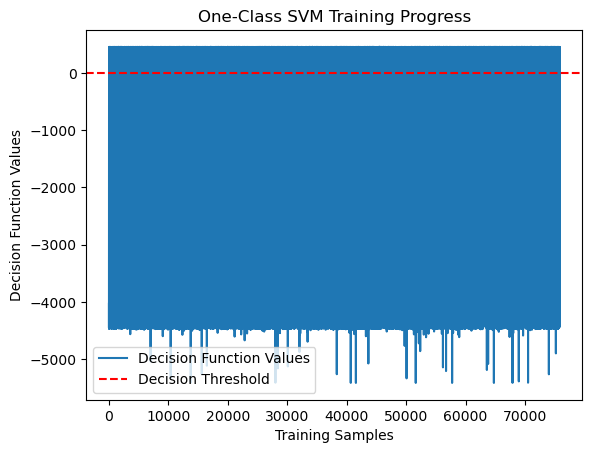

In [8]:
# Get decision function values for training samples
decision_values = model.decision_function(X_train)

# Visualize decision function values during training
plt.plot(np.arange(len(decision_values)), decision_values, label='Decision Function Values')
plt.axhline(0, color='red', linestyle='--', label='Decision Threshold')
plt.xlabel('Training Samples')
plt.ylabel('Decision Function Values')
plt.title('One-Class SVM Training Progress')
plt.legend()
plt.show()

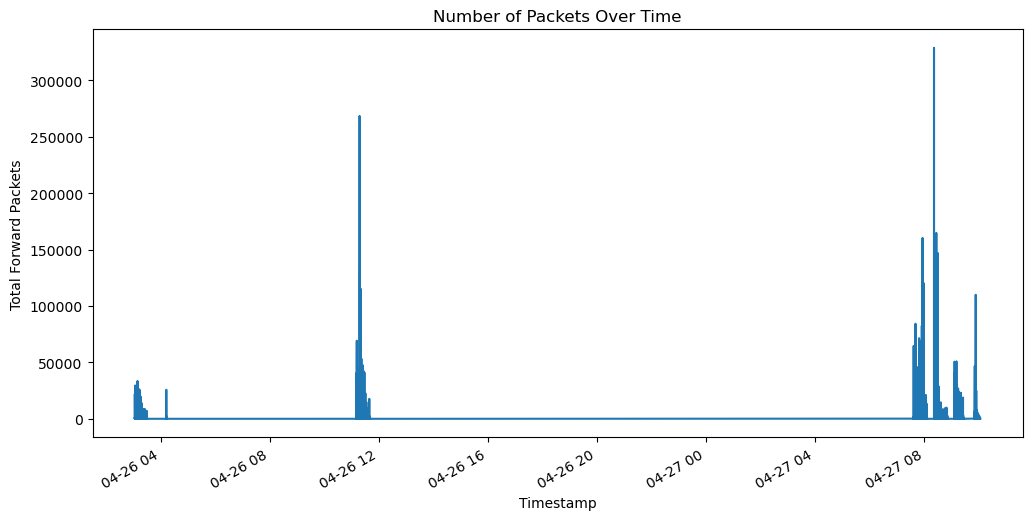

In [9]:
plt.figure(figsize=(12, 6))
df.set_index('Timestamp')['Total.Fwd.Packets'].plot()
plt.title('Number of Packets Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Total Forward Packets')
plt.show()


In [10]:
# Example: Generating alerts for anomalous instances
alerts = df.loc[y_test[y_pred == -1].index]
print("Anomalous Instances:")
print(alerts[['Timestamp', 'Total.Fwd.Packets', 'Total.Backward.Packets', 'Label']])


Anomalous Instances:
                 Timestamp  Total.Fwd.Packets  Total.Backward.Packets   Label
504041 2017-04-27 08:26:02                 36                      38  BENIGN
482223 2017-04-27 08:23:04                  9                       4  BENIGN
108705 2017-04-26 11:20:07              10368                    2163  BENIGN
220799 2017-04-26 03:03:42                 10                       9  BENIGN
28522  2017-04-26 11:11:30                  9                      10  BENIGN
...                    ...                ...                     ...     ...
668601 2017-04-27 09:21:40                 15                      11  BENIGN
210526 2017-04-26 03:15:00                  9                       6  BENIGN
190220 2017-04-26 03:07:19                220                     179  BENIGN
722127 2017-04-27 09:18:38               1260                    1158  BENIGN
493131 2017-04-27 08:27:42                 38                      32  BENIGN

[172367 rows x 4 columns]


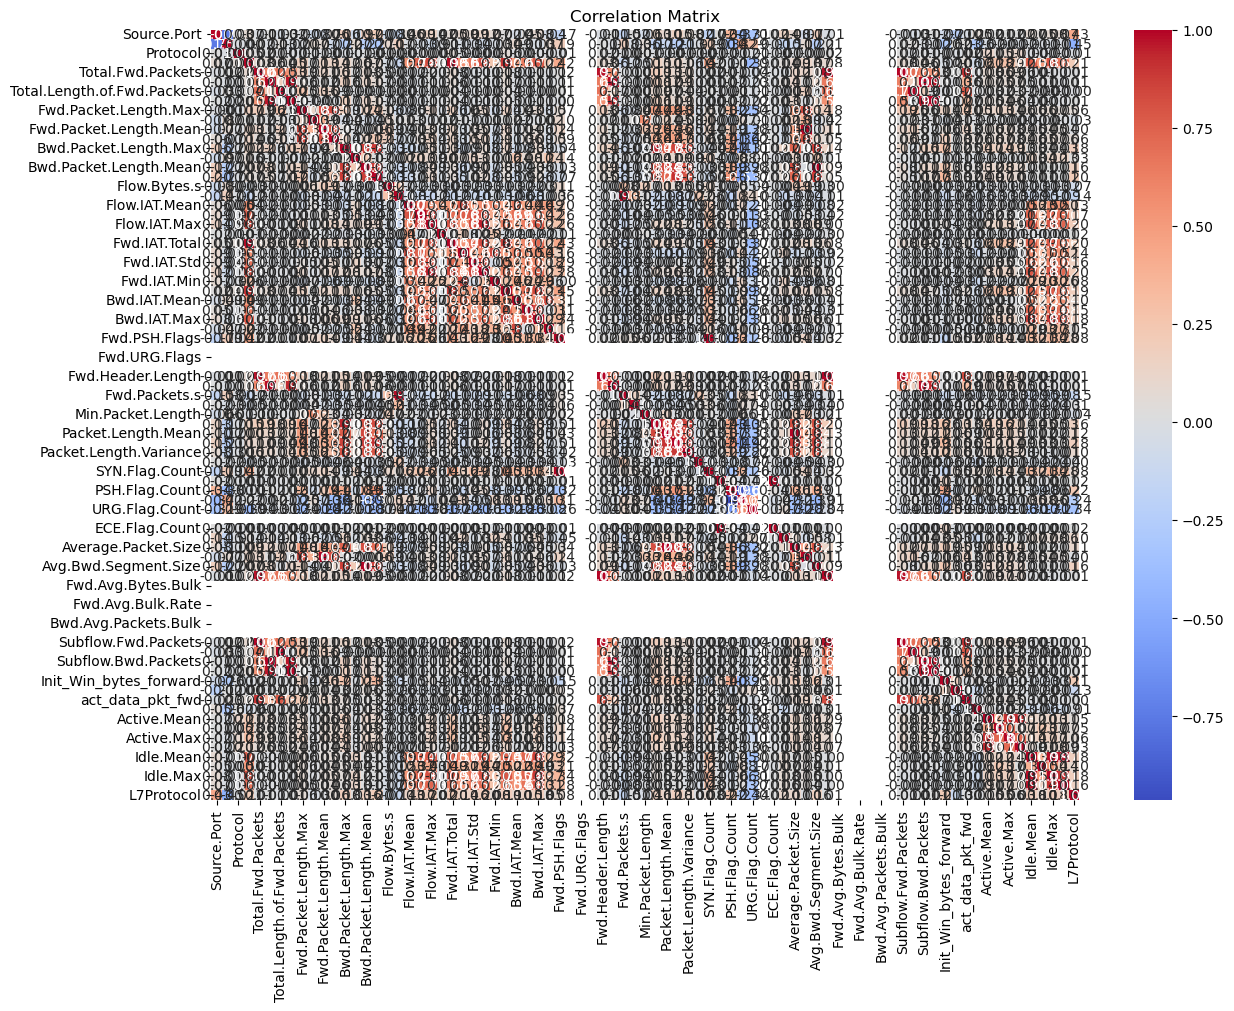

In [11]:
import seaborn as sns

# Example: Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


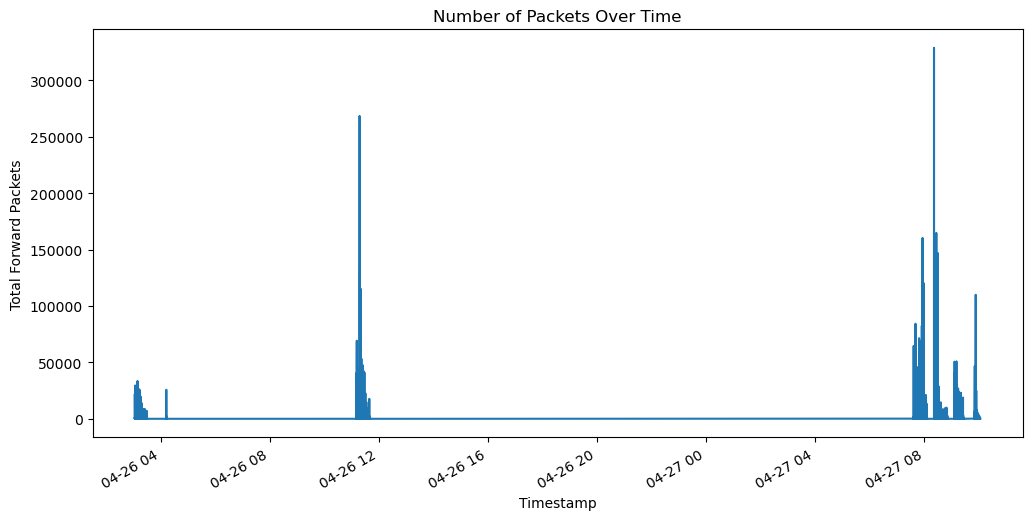

In [12]:
# Example: Plotting the number of packets over time
plt.figure(figsize=(12, 6))
df.set_index('Timestamp')['Total.Fwd.Packets'].plot()
plt.title('Number of Packets Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Total Forward Packets')
plt.show()


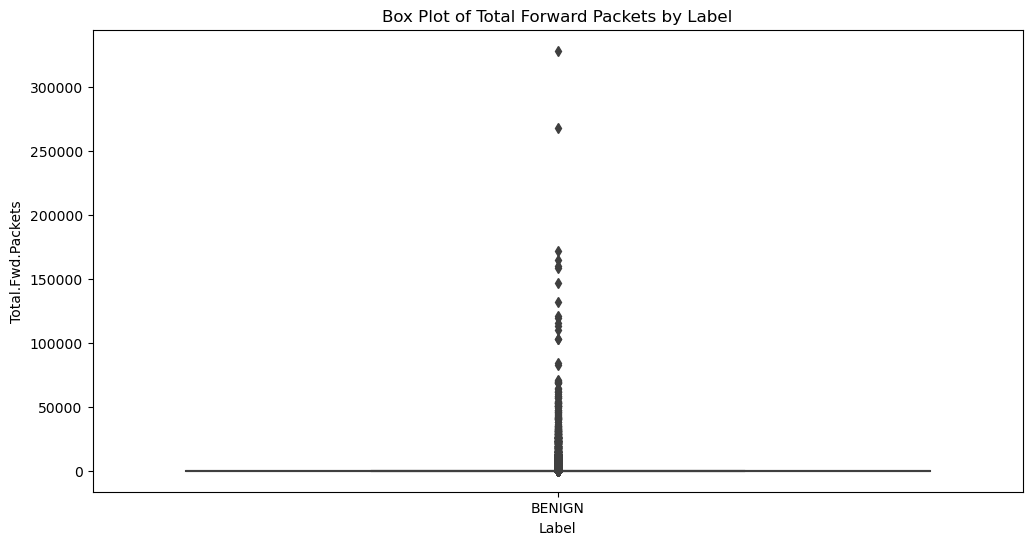

In [13]:
# Example: Box plot of 'Total.Fwd.Packets' for different labels
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Total.Fwd.Packets', data=df)
plt.title('Box Plot of Total Forward Packets by Label')
plt.show()


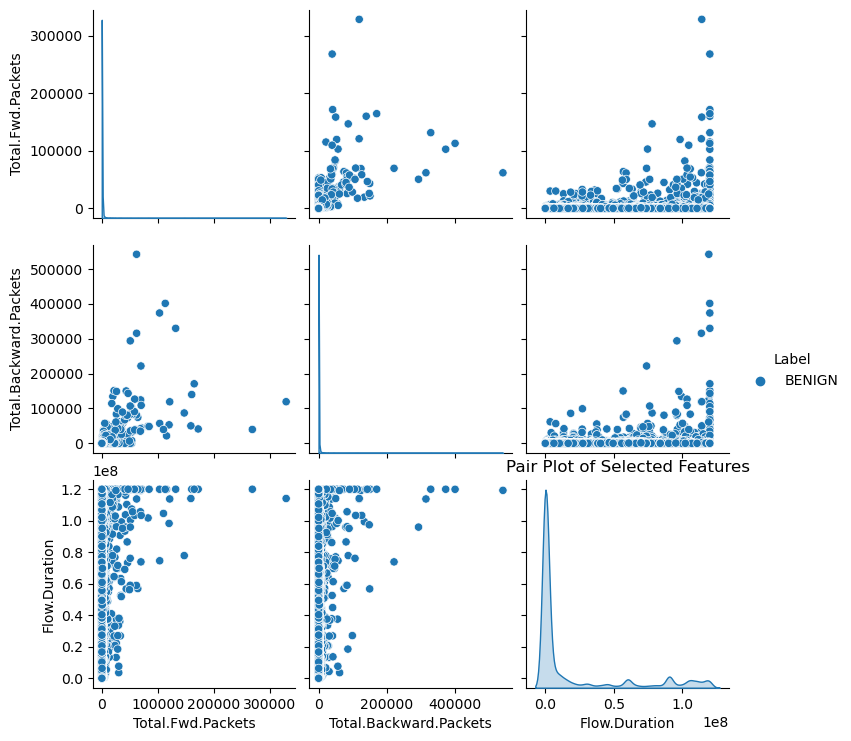

In [14]:
# Example: Pair plot of selected features
sns.pairplot(df[['Total.Fwd.Packets', 'Total.Backward.Packets', 'Flow.Duration', 'Label']], hue='Label')
plt.title('Pair Plot of Selected Features')
plt.show()


# Random Forest

In [15]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed
rf_model.fit(X_train, y_train)

# Predict on the testing set
rf_y_pred = rf_model.predict(X_test)

# Drop rows with nan values in y_test
y_test = y_test.dropna()
rf_y_pred = rf_y_pred[:len(y_test)]  # Ensure lengths match

rf_y_pred = rf_y_pred.astype(str)  # or another appropriate data type



# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_classification_rep = classification_report(y_test, rf_y_pred)

print("Random Forest Model:")
print(f'Accuracy: {rf_accuracy}')
print('Classification Report:')
print(rf_classification_rep)


Random Forest Model:
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    682639

    accuracy                           1.00    682639
   macro avg       1.00      1.00      1.00    682639
weighted avg       1.00      1.00      1.00    682639



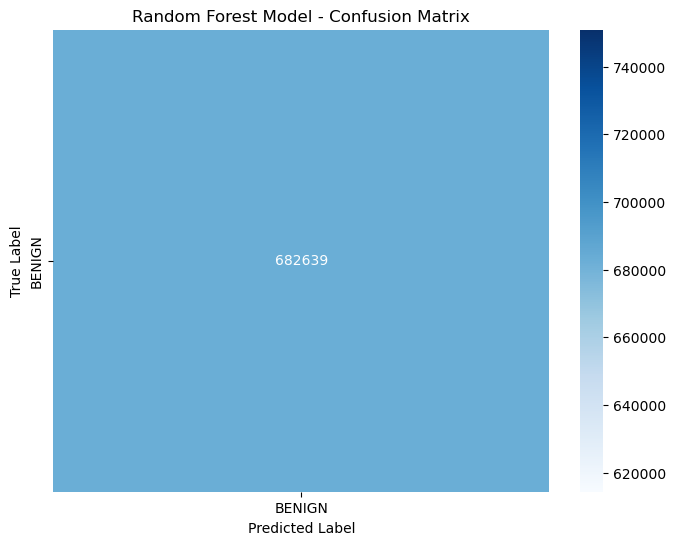

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Random Forest Model - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

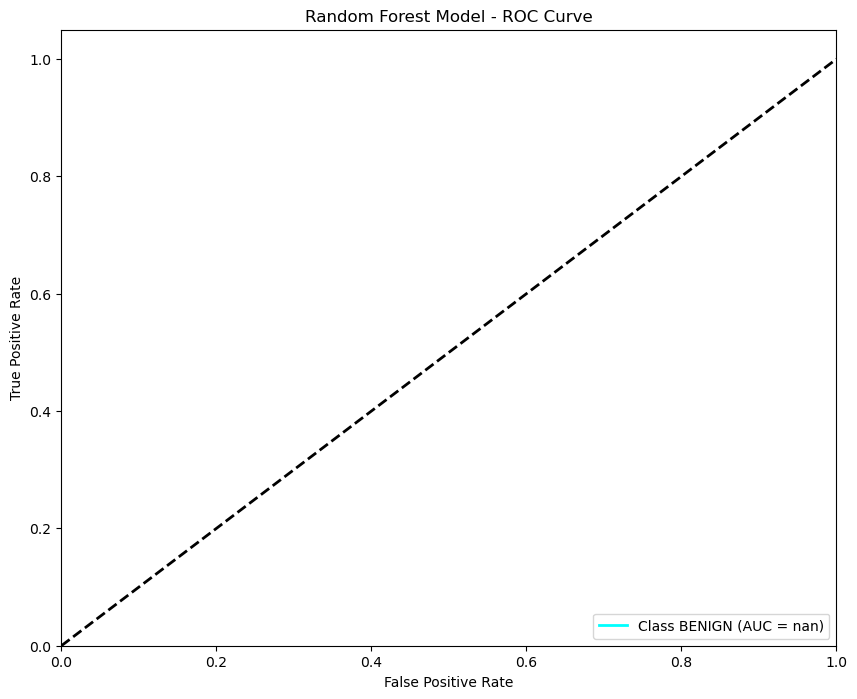

In [17]:
# ROC Curve (if applicable for your multiclass problem)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for only the valid samples
y_bin = label_binarize(y_test, classes=rf_model.classes_)

# Ensure lengths match
if len(y_bin) > len(rf_y_pred):
    y_bin = y_bin[:len(rf_y_pred)]

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(rf_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], rf_model.predict_proba(X_test.iloc[:len(y_bin)])[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(rf_model.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {rf_model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model - ROC Curve')
plt.legend(loc="lower right")
plt.show()

# MLP

In [19]:
# Import necessary libraries
from sklearn.neural_network import MLPClassifier

# Train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  # Adjust parameters as needed
mlp_model.fit(X_train, y_train)

# Predict on the testing set
mlp_y_pred = mlp_model.predict(X_test)

# Handle NaN values
y_test = y_test.dropna()

# Ensure lengths match
min_len = min(len(y_test), len(mlp_y_pred))
y_test = y_test[:min_len]
mlp_y_pred = mlp_y_pred[:min_len]

# Convert Data Types if needed
mlp_y_pred = mlp_y_pred.astype(str)  # or another appropriate data type

# Evaluate the MLP model
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)
mlp_classification_rep = classification_report(y_test, mlp_y_pred)

print("MLP Model:")
print(f'Accuracy: {mlp_accuracy}')
print('Classification Report:')
print(mlp_classification_rep)

MLP Model:
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    682639

    accuracy                           1.00    682639
   macro avg       1.00      1.00      1.00    682639
weighted avg       1.00      1.00      1.00    682639



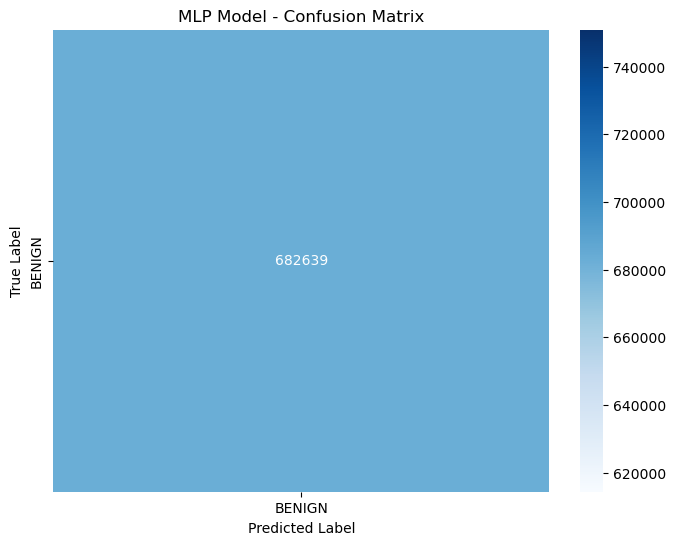

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Confusion Matrix
conf_matrix_mlp = confusion_matrix(y_test, mlp_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=mlp_model.classes_, yticklabels=mlp_model.classes_)
plt.title("MLP Model - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

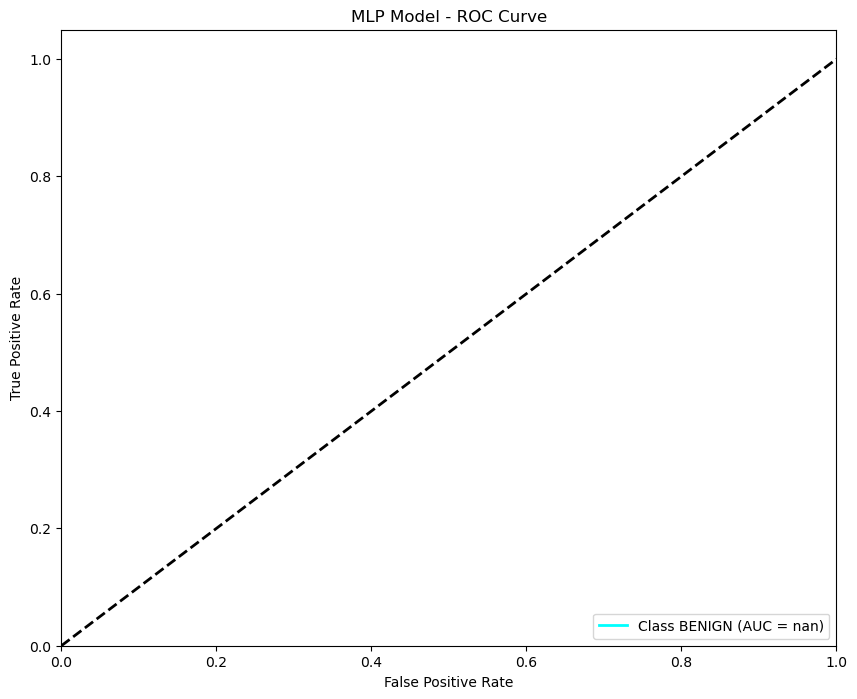

In [21]:
# ROC Curve (if applicable for your multiclass problem)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for only the valid samples
y_bin_mlp = label_binarize(y_test, classes=mlp_model.classes_)

# Ensure lengths match
if len(y_bin_mlp) > len(mlp_y_pred):
    y_bin_mlp = y_bin_mlp[:len(mlp_y_pred)]

# Calculate ROC curve and ROC area for each class
fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()

for i in range(len(mlp_model.classes_)):
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(y_bin_mlp[:, i], mlp_model.predict_proba(X_test.iloc[:len(y_bin_mlp)])[:, i])
    roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(mlp_model.classes_)), colors):
    plt.plot(fpr_mlp[i], tpr_mlp[i], color=color, lw=2, label=f'Class {mlp_model.classes_[i]} (AUC = {roc_auc_mlp[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Model - ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Comparitive analysis

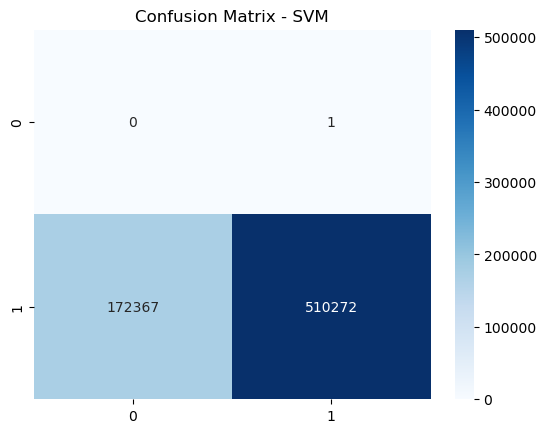

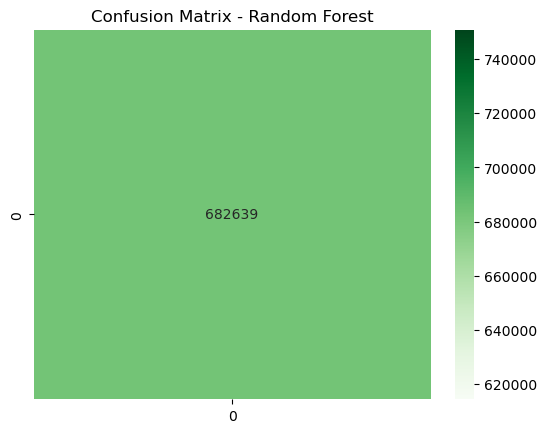

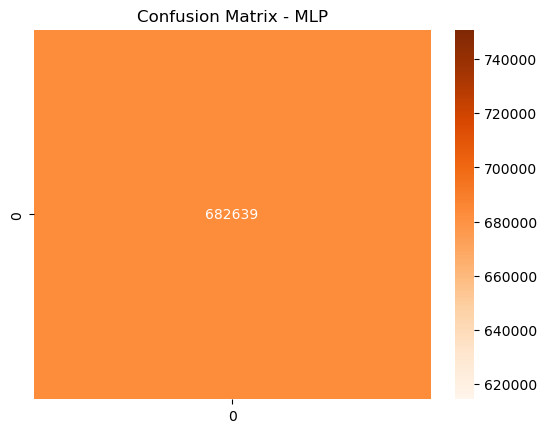

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# SVM
sns.heatmap(confusion_matrix(y_test_numeric, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.show()

# Random Forest
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# MLP
sns.heatmap(confusion_matrix(y_test, mlp_y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - MLP')
plt.show()


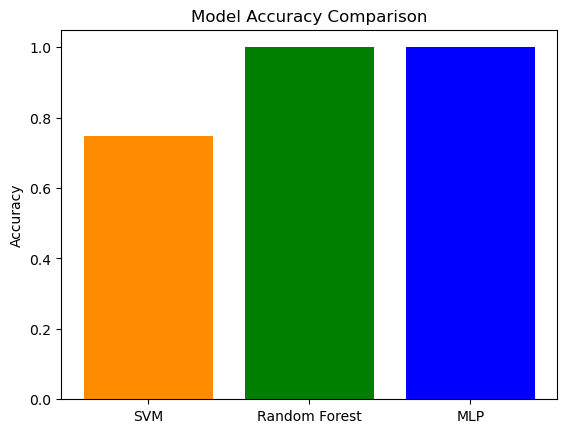

In [29]:
# Accuracy values for each model
accuracies = [accuracy, rf_accuracy, mlp_accuracy]

# Plotting the bar chart
plt.bar(['SVM', 'Random Forest', 'MLP'], accuracies, color=['darkorange', 'green', 'blue'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()


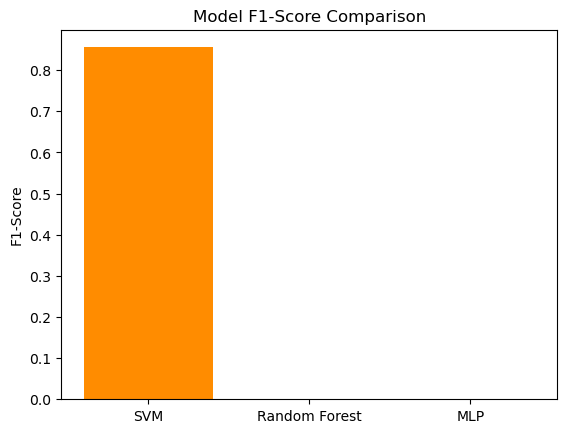

In [26]:
from sklearn.metrics import f1_score

# F1-Score values for each model
f1_scores = [f1_score(y_test_numeric, y_pred), f1_score(y_test, rf_y_pred), f1_score(y_test, mlp_y_pred)]

# Plotting the bar chart
plt.bar(['SVM', 'Random Forest', 'MLP'], f1_scores, color=['darkorange', 'green', 'blue'])
plt.ylabel('F1-Score')
plt.title('Model F1-Score Comparison')
plt.show()


# CNN

In [30]:
# Encode categorical labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Extract features for analysis
features = df[['Flow.Duration', 'Total.Fwd.Packets', 'Total.Backward.Packets', 'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets']]

# Split the data into features and target label
X = features.values
y = df['Label'].values

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for CNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predict on the testing set
y_pred = (model.predict(X_test) > 0.5).astype("int32")



Epoch 1/10
9482/9482 [==============================] - 63s 6ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 7.8204e-07 - val_accuracy: 1.0000
Epoch 2/10
9482/9482 [==============================] - 52s 6ms/step - loss: 2.7653e-05 - accuracy: 1.0000 - val_loss: 4.8192e-09 - val_accuracy: 1.0000
Epoch 3/10
9482/9482 [==============================] - 52s 6ms/step - loss: 3.3639e-05 - accuracy: 1.0000 - val_loss: 1.3105e-08 - val_accuracy: 1.0000
Epoch 4/10
9482/9482 [==============================] - 53s 6ms/step - loss: 3.3292e-05 - accuracy: 1.0000 - val_loss: 1.3296e-09 - val_accuracy: 1.0000
Epoch 5/10
9482/9482 [==============================] - 56s 6ms/step - loss: 3.5513e-05 - accuracy: 1.0000 - val_loss: 4.1377e-09 - val_accuracy: 1.0000
Epoch 6/10
9482/9482 [==============================] - 59s 6ms/step - loss: 3.6051e-05 - accuracy: 1.0000 - val_loss: 1.9457e-09 - val_accuracy: 1.0000
Epoch 7/10
9482/9482 [==============================] - 62s 7ms/step - loss: 3.6222e-0

In [31]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    151698

    accuracy                           1.00    151698
   macro avg       1.00      1.00      1.00    151698
weighted avg       1.00      1.00      1.00    151698



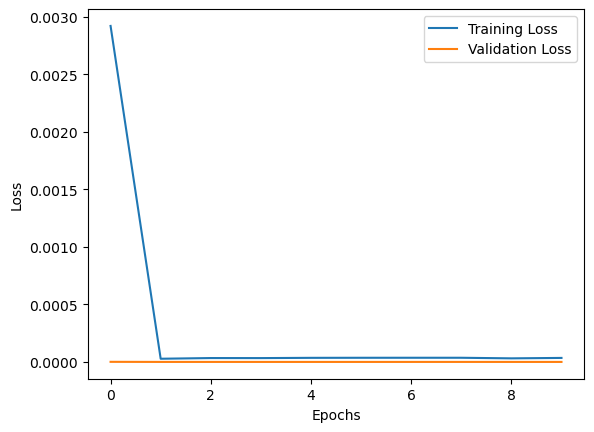

In [32]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


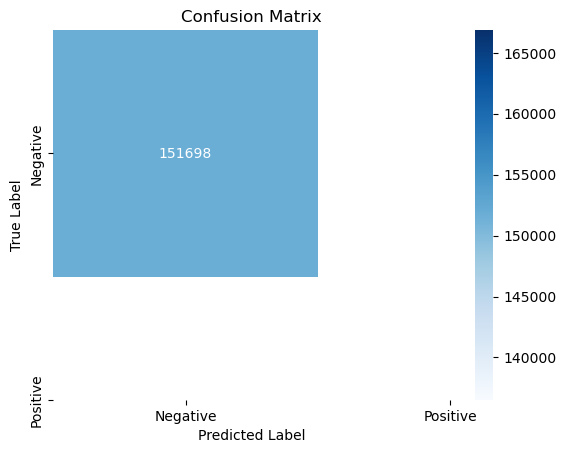

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
